In [1]:
import numpy as np
from helpers import *
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def initialize_parameters(layers_size):
    """
    Returns parameters ('W1', 'b1', W2', 'b2', ...)
    """
    
    parameters = {}
    for l in range(1, len(layers_size)):
        parameters['W' + str(l)] = np.random.randn(layers_size[l], layers_size[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_size[l], 1))
    
    return parameters

In [3]:
def linearize_and_activate_forward_unit(A_previous, W, b, activation_function='relu'):
    """
    Returns A, layer_parameters(W, b, Z, A)
    """
    
    Z = np.dot(W, A_previous) + b
    if activation_function == 'relu':
        A = relu(Z)
    elif activation_function == 'sigmoid':
        A = sigmoid(Z)
    
    layer_parameters = {
        'W': W,
        'b': b,
        'Z': Z,
        'A': A_previous
    }
    
    return A, layer_parameters

In [4]:
def deep_forward(X, parameters):
    n_of_layers = len(parameters) // 2
    A = X
    layers_parameters = []
    
    W = parameters
    
    for l in range(1, n_of_layers):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, params = linearize_and_activate_forward_unit(A, W, b, 'relu')
        layers_parameters.append(params)
    # Last layer
    W = parameters['W' + str(n_of_layers)]
    b = parameters['b' + str(n_of_layers)]
    A_last, params = linearize_and_activate_forward_unit(A, W, b, 'sigmoid')
    layers_parameters.append(params)
    
    return A_last, layers_parameters

In [5]:
def calculate_cost(Y_hat, Y):
    """
    Returns cost
    """
    m = Y.shape[1]
    
    log_probs = np.multiply(Y, np.log(Y_hat)) + np.multiply(1 - Y, np.log(1 - Y_hat))
    cost = -(1/m) * np.sum(log_probs)
    
    cost = np.squeeze(cost)
    
    return cost

In [6]:
def propagate_back_activation(dA, Z, activation):
    """
    Returns dZ[L]
    """
    if activation == 'relu':
        dZ = np.multiply(dA, relu_derivative(Z))
    elif activation == 'sigmoid':
        dZ = np.multiply(dA, sigmoid_derivative(Z))
    
    return dZ

In [7]:
# Add A_prev, W, b to the cache
def propagate_back_linear(layer_parameters, dZ):
    """
    Returns dA, dW, db
    """
    W = layer_parameters['W']
    b = layer_parameters['b']
    A_previous = layer_parameters['A']
    m = A_previous.shape[1]
    
    dW = (1/m) * np.dot(dZ, A_previous.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_previous = np.dot(W.T, dZ)
    
    return dA_previous, dW, db

In [8]:
def backward_propagation_unit(dA, layer_parameters, activation):
    W = layer_parameters['W']
    b = layer_parameters['b']
    Z = layer_parameters['Z']
    A_previous = layer_parameters['A']
    dZ = propagate_back_activation(dA, Z, activation)
    dA_previous, dW, db = propagate_back_linear(layer_parameters, dZ)
    
    return dA_previous, dW, db

In [9]:
def deep_backward(AL, Y, layers_parameters):
    """
    layer_parameters: W, b, Z, A
    """
    m = Y.shape[1]
    layers_number = len(layers_parameters)
    Y = Y.reshape(AL.shape)
    gradients = {}
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    gradients['dA' + str(layers_number-1)], \
    gradients['dW' + str(layers_number)], \
    gradients['db' + str(layers_number)] = backward_propagation_unit(dAL, layers_parameters[-1], 'sigmoid')
    
    for l in reversed(range(layers_number-1)):
        current_layer_params = layers_parameters[l]
        gradients['dA' + str(l)], \
        gradients['dW' + str(l+1)], \
        gradients['db' + str(l+1)] = backward_propagation_unit(gradients['dA' + str(l+1)], 
                                                               layers_parameters[l], 
                                                               'relu') 
    return gradients

In [10]:
def update_weights(parameters, gradients, learning_rate):
    n_of_layers = len(parameters) // 2
    
    for l in range(n_of_layers):
        parameters['W' + str(l+1)] -= learning_rate * gradients['dW' + str(l+1)]
        parameters['b' + str(l+1)] -= learning_rate * gradients['db' + str(l+1)]
    
    return parameters

In [11]:
parameters = initialize_parameters([4,4,2,1])
X = np.array([[0,1,0],[1,0,1],[1,2,1],[2,2,1]])
Y = np.array([[1,0,1]])
A, layers_parameters = deep_forward(X, parameters)
gradients = deep_backward(A, Y, layers_parameters)
gradients
parameters = update_weights(parameters,gradients, 0.04)
parameters

{'W1': array([[ 0.01624345, -0.00611756, -0.00528172, -0.01072969],
        [ 0.0086546 , -0.02301539,  0.01744916, -0.00761103],
        [ 0.00319039, -0.0024937 ,  0.01462108, -0.02060141],
        [-0.00322417, -0.00384054,  0.01133769, -0.01099891]]),
 'W2': array([[-0.00172428, -0.00877858,  0.00042214,  0.00582815],
        [-0.01100619,  0.01144853,  0.00901591,  0.00502494]]),
 'W3': array([[ 0.00900856, -0.00683944]]),
 'b1': array([[  0.00000000e+00],
        [  5.21785749e-07],
        [  0.00000000e+00],
        [  0.00000000e+00]]),
 'b2': array([[  1.20114127e-04],
        [ -4.55819078e-05]]),
 'b3': array([[ 0.00666667]])}

In [12]:
def deep_NN_model(X, Y, layers_size, learning_rate=0.0075, n_iters=3000):
    costs = []
    parameters = initialize_parameters(layers_size)
    
    for i in range(n_iters):
        A_last, layers_parameters = deep_forward(X, parameters)
        cost = calculate_cost(A_last, Y)
        gradients = deep_backward(A_last, Y, layers_parameters)
        parameters = update_weights(parameters, gradients, learning_rate)
        
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [13]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


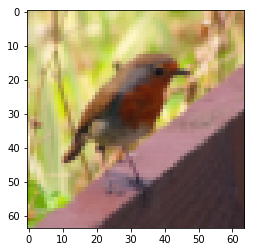

In [14]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [15]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]


# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.678009
Cost after iteration 200: 0.667597
Cost after iteration 300: 0.660419
Cost after iteration 400: 0.655455
Cost after iteration 500: 0.652011
Cost after iteration 600: 0.649614
Cost after iteration 700: 0.647940
Cost after iteration 800: 0.646768
Cost after iteration 900: 0.645946
Cost after iteration 1000: 0.645367
Cost after iteration 1100: 0.644960
Cost after iteration 1200: 0.644672
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


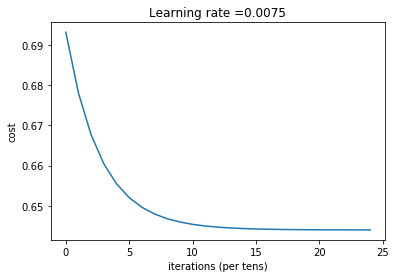

In [16]:
layers_size = [12288, 20, 7, 5, 1]
parameters = deep_NN_model(train_x, train_y, layers_size, n_iters=2500)

In [27]:
def predict(X, y, parameters, layers_size):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    # Forward propagation
    probas = deep_NN_model(X, y, layers_size)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.678009
Cost after iteration 200: 0.667598
Cost after iteration 300: 0.660420
Cost after iteration 400: 0.655456
Cost after iteration 500: 0.652012
Cost after iteration 600: 0.649614
Cost after iteration 700: 0.647940
Cost after iteration 800: 0.646769
Cost after iteration 900: 0.645946
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644960
Cost after iteration 1200: 0.644672
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985
Cost after iteration 2500: 0.643982
Cost after iteration 2600: 0.643980
Cost after iteration 2700: 0.643978
Cost

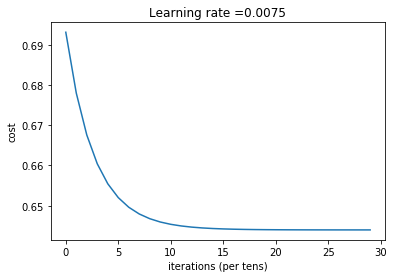

AttributeError: 'dict' object has no attribute 'shape'

In [28]:
predictions_train = predict(train_x, train_y, parameters, layers_size)